In [1]:
import pandas as pd
import requests
import os
from collections import defaultdict
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["font.size"] = 16

In [3]:
# load breaks data, downloading on the first time if necessary:
# https://data-cityofmadison.opendata.arcgis.com/datasets/water-main-breaks
url = "https://opendata.arcgis.com/datasets/7bafc50c75fe430e9bac6edd72126c0a_5.csv"

if not os.path.exists("breaks.csv"):
    print("DOWNLOAD")
    df = pd.read_csv(url)
    df.to_csv("breaks.csv", index=False)

df = pd.read_csv("breaks.csv")
print(df.shape)
df.head()

(7002, 46)


,X,Y,OBJECTID,Cell_rotation,mslink,break_num,pipe_mslink,pipe_type,break_date,house_num,...,created_user,created_date,last_edited_user,last_edited_date,BreakType,BreakTypeOther,StreetSegmentID,CWWOID,CWWOClosedDate,TotalHoursWaterOff
0,-89.402108,43.067694,1,359.603239,1.0,225.0,18715.0,MAIN,2007/11/01 00:00:00+00,918.0,...,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,NaN,4996.0,NaN,1970/01/01 00:00:00+00,NaN
1,-89.353687,43.109985,3,359.602939,27.0,226.0,15257.0,MAIN,2007/11/02 00:00:00+00,2255.0,...,NaN,1970/01/01 00:00:00+00,WUPTB,2018/02/15 14:38:16+00,NaN,NaN,2031.0,NaN,1970/01/01 00:00:00+00,NaN
2,-89.323967,43.088787,4,359.602863,28.0,227.0,12532.0,MAIN,2007/11/05 00:00:00+00,3701.0,...,NaN,1970/01/01 00:00:00+00,WUPTB,2018/02/15 14:38:16+00,NaN,NaN,2610.0,NaN,1970/01/01 00:00:00+00,NaN
3,-89.295381,43.090665,5,44.602085,30.0,228.0,11178.0,MAIN,2007/11/07 00:00:00+00,533.0,...,NaN,1970/01/01 00:00:00+00,WUPTB,2018/02/15 14:38:16+00,NaN,NaN,3299.0,NaN,1970/01/01 00:00:00+00,NaN
4,-89.318239,43.089422,7,359.602838,32.0,230.0,12647.0,MAIN,2007/11/09 00:00:00+00,3906.0,...,NaN,1970/01/01 00:00:00+00,WUPTB,2018/02/15 14:38:16+00,NaN,NaN,3055.0,NaN,1970/01/01 00:00:00+00,NaN


In [4]:
df["break_date"].str.find("1970/01/01").value_counts() / len(df)

-1    0.542559
 0    0.457441
Name: break_date, dtype: float64

In [5]:
df["soil_type"].value_counts()

Clay                  1177
clay                   526
sand                   181
Clay, rock             143
Sand                   137
                      ... 
Clay, sand, gravel       1
Gravel/Sand              1
Sand, boulders           1
sandy/rock               1
Landfill junk            1
Name: soil_type, Length: 328, dtype: int64

In [6]:
print(", ".join(df.columns))

X, Y, OBJECTID, Cell_rotation, mslink, break_num, pipe_mslink, pipe_type, break_date, house_num, street_dir, street_name, street_type, Location, time_received, time_at_scene, time_off, time_on, num_bldgs_off, pipe_size, pipe_depth_ft, frost_depth_in, soil_type, remarks, break_year, break_month, break_day, materials_used, MainID, AssetCode, PageNumber, AssetNumber, FacilityID, MainRetired, BreakID, ICOUNT, created_user, created_date, last_edited_user, last_edited_date, BreakType, BreakTypeOther, StreetSegmentID, CWWOID, CWWOClosedDate, TotalHoursWaterOff


In [7]:
columns = ["MainID", "pipe_size", "pipe_depth_ft", "soil_type", "break_date", "break_month"]
mains = df[(df["pipe_type"] == "MAIN") & (df["break_date"].str.find("1970/01/01") == -1)][columns].copy()

# soil type
for t in ["clay", "rock", "sand", "gravel"]:
    mains[t] = (df["soil_type"].str.lower().str.find(t) >= 0).astype(int)
mains.drop(columns=["soil_type"], inplace=True)

# season
mains["break_month"] = mains["break_date"].str.split("/", expand=True)[1].astype(int)
mains["winter"] = mains["break_month"].isin([12,1,2])
mains.loc[mains["break_month"].isna(), "winter"] = float("nan")

# count up towards most recent date (which is numbered 0)
mains["break_date"] = pd.to_datetime(df["break_date"])
mains["break_date"] = (mains["break_date"] - mains["break_date"].max()) / timedelta(days=1)
mains = mains.sort_values(by="break_date").copy()
mains

,MainID,pipe_size,pipe_depth_ft,break_date,break_month,clay,rock,sand,gravel,winter
4106,MAIN-6943-13636,NaN,NaN,-8435.0,1,0,0,0,0,1.0
2661,MAIN-6336-18809,NaN,NaN,-8402.0,2,0,0,0,0,1.0
2800,MAIN-5744-15604,10.0,3.0,-8156.0,10,1,0,1,0,0.0
4108,MAIN-3749-6440,NaN,NaN,-7859.0,8,0,0,0,0,0.0
4109,MAIN-6860-16497,NaN,NaN,-7839.0,8,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
6833,MAIN-4949-5931,NaN,NaN,-131.0,9,0,0,0,0,0.0
6834,MAIN-2859-4488,NaN,NaN,-127.0,10,0,0,0,0,0.0
6837,MAIN-6729-19170,NaN,NaN,-123.0,10,0,0,0,0,0.0
6917,MAIN-6529-18046,NaN,NaN,0.0,2,0,0,0,0,1.0


In [8]:
# total number of breaks
prior_breaks = defaultdict(int)
for i in mains.index:
    mainID = mains.at[i, "MainID"]
    mains.at[i, "prior_breaks"] = prior_breaks[mainID]
    prior_breaks[mainID] += 1

# time until next break
next_break = {} # key: MainID, val: date (as a negative int) of next break
mains["next_break"] = float("inf")
for i in reversed(mains.index):
    mainID, day = mains.at[i, "MainID"], mains.at[i, "break_date"]
    if mainID in next_break:
        mains.at[i, "next_break"] = next_break[mainID] - day
    next_break[mainID] = day

# does it break again in the given time window?
# filter out the most recent data for which we don't know the whole window yet
time_window = 5 * 365
mains["break_again"] = (mains["next_break"] > 0) & (mains["next_break"] < time_window)
mains = mains[mains["break_date"] < -time_window]
mains = mains.reset_index(drop=True).copy()
mains

,MainID,pipe_size,pipe_depth_ft,break_date,break_month,clay,rock,sand,gravel,winter,prior_breaks,next_break,break_again
0,MAIN-6943-13636,NaN,NaN,-8435.0,1,0,0,0,0,1.0,0.0,3961.0,False
1,MAIN-6336-18809,NaN,NaN,-8402.0,2,0,0,0,0,1.0,0.0,5081.0,False
2,MAIN-5744-15604,10.0,3.00,-8156.0,10,1,0,1,0,0.0,0.0,inf,False
3,MAIN-3749-6440,NaN,NaN,-7859.0,8,0,0,0,0,0.0,0.0,934.0,True
4,MAIN-6860-16497,NaN,NaN,-7839.0,8,0,0,0,0,0.0,0.0,inf,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694,MAIN-6553-14844,6.0,5.50,-1830.0,2,0,0,1,0,1.0,0.0,inf,False
2695,MAIN-4922-17390,6.0,5.67,-1829.0,2,1,0,0,0,1.0,0.0,inf,False
2696,MAIN-3247-6353,6.0,5.50,-1827.0,2,1,0,0,0,1.0,4.0,inf,False
2697,MAIN-3348-6424,6.0,5.00,-1827.0,2,1,0,0,0,1.0,4.0,36.0,True


In [9]:
(-mains["break_date"].min()) / 365

23.10958904109589

In [10]:
years = (mains["break_date"].max() - mains["break_date"].min()) / 365
years

18.106849315068494

Text(0.5, 1.0, 'Figure 1: Seasonal Effect on Breaks')

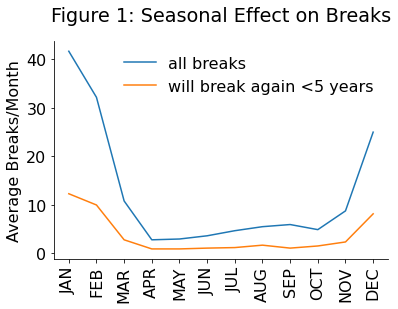

In [11]:
all_breaks = mains["break_month"].value_counts().sort_index() / years
will_repeat = mains[mains["break_again"]]["break_month"].value_counts().sort_index() / years
ax = all_breaks.plot.line(label="all breaks")
will_repeat.plot.line(ax=ax, label="will break again <5 years")
ax.legend(frameon=False)
ax.set_xticks(range(1,13))
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"], rotation=90)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_ylabel("Average Breaks/Month")
ax.set_title("Figure 1: Seasonal Effect on Breaks", pad=20)

In [12]:
mains["break_month"].value_counts()

1     755
2     583
12    453
3     196
11    159
9     108
8     100
10     89
7      85
6      66
5      54
4      51
Name: break_month, dtype: int64

In [13]:
dist = mains["break_month"].value_counts() / len(mains)
print(dist[:3].sum())
dist

0.6635791033716191


1     0.279733
2     0.216006
12    0.167840
3     0.072619
11    0.058911
9     0.040015
8     0.037051
10    0.032975
7     0.031493
6     0.024454
5     0.020007
4     0.018896
Name: break_month, dtype: float64

In [14]:
break_again = mains[mains["break_again"]]
dist = break_again["break_month"].value_counts() / len(break_again)
print(dist[:3].sum())
dist

0.6891385767790262


1     0.278402
2     0.225968
12    0.184769
3     0.063670
11    0.053683
8     0.038702
10    0.034956
7     0.027466
9     0.024969
6     0.024969
5     0.021223
4     0.021223
Name: break_month, dtype: float64

In [15]:
mains["break_again"].value_counts() / len(mains)

False    0.703223
True     0.296777
Name: break_again, dtype: float64

In [16]:
xcols = ["prior_breaks", "pipe_size", "pipe_depth_ft", "winter", "clay", "rock", "sand", "gravel"]
ycol = "break_again"

1    0.487680
2    0.756154
3    0.852926
4    0.901201
5    0.940919
6    0.969069
7    0.990057
8    1.000000
dtype: float64
1    0.183516
2    0.338329
3    0.474075
4    0.598280
5    0.717168
6    0.823405
7    0.919942
8    1.000000
dtype: float64


Text(0.5, 1.0, 'Figure 2: Principal Components of Breaks')

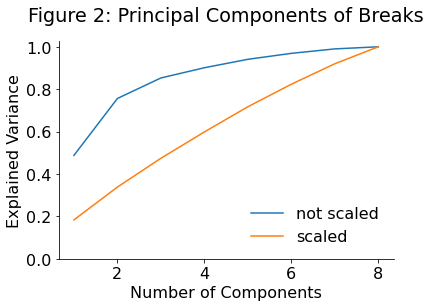

In [17]:
def explained(scale):
    stages = [("imp", SimpleImputer(strategy="most_frequent"))]
    if scale:
        stages.append(("std", StandardScaler()))
    stages.append(("pca", PCA()))
    p = Pipeline(stages)
    p.fit(mains[xcols])
    #print(p["pca"].components_.round(2))
    explained = p["pca"].explained_variance_
    s = pd.Series(explained.cumsum() / explained.sum(),
                  index=range(1, len(xcols)+1))
    print(s)
    return s
ax = explained(False).plot.line(label="not scaled", ylim=0)
explained(True).plot.line(label="scaled", ax=ax)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Explained Variance")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False)
ax.set_title("Figure 2: Principal Components of Breaks", pad=20)

In [18]:
train, test = train_test_split(mains, stratify=mains["break_again"], random_state=0)
train.shape, test.shape

((2024, 13), (675, 13))

In [19]:
def do_eval(balanced=None):
    p = Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("std", StandardScaler()),
        ("lr", LogisticRegression(class_weight=balanced)),
    ])
    p.fit(train[xcols], train[ycol])
    print("Score", p.score(test[xcols], test[ycol]))
    print("Recall", recall_score(test[ycol], p.predict(test[xcols])))
    print("Precision", precision_score(test[ycol], p.predict(test[xcols])))
    print(confusion_matrix(test[ycol], p.predict(test[xcols])) / len(test) * 100)
    return p
p = do_eval()
p = do_eval("balanced")

Score 0.7125925925925926
Recall 0.11
Precision 0.5789473684210527
[[68.          2.37037037]
 [26.37037037  3.25925926]]
Score 0.6533333333333333
Recall 0.55
Precision 0.4330708661417323
[[49.03703704 21.33333333]
 [13.33333333 16.2962963 ]]


Text(0.5, 1.0, 'Figure 3: Logistic Regression Coefficients')

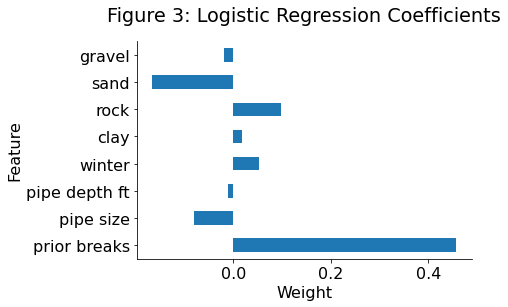

In [20]:
idx = [t.replace("_", " ") for t in xcols]
ax = pd.Series(p["lr"].coef_[0], index=idx).plot.barh()
ax.set_xlabel("Weight")
ax.set_ylabel("Feature")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Figure 3: Logistic Regression Coefficients", pad=20)